In [1]:
import pandas as pd
import recordlinkage
from recordlinkage.preprocessing import clean
import re


# https://pypi.org/project/recordlinkage/
import recordlinkage
from recordlinkage.preprocessing import clean

# because i have ~20columns
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_parquet('veridion_entity_resolution_challenge.snappy.parquet')  
print(df.head())

               company_name company_legal_names  company_commercial_names  \
0             Owens Liquors                None             Owens Liquors   
1              Club Tarneit                None              Club Tarneit   
2  AAA Auto Otrokovice Zlín                None  AAA Auto Otrokovice Zlín   
3             Gisinger GmbH       Gisinger GmbH                      None   
4               Kasana Life                None               Kasana Life   

  main_country_code   main_country        main_region      main_city_district  \
0                US  United States     South Carolina                    None   
1                AU      Australia           Victoria                 Tarneit   
2                CZ        Czechia               Zlín  Kvítkovice U Otrokovic   
3                DE        Germany  Baden-Württemberg                    None   
4                US  United States        Connecticut                    None   

             main_city main_postcode     main_stre

# Important columns
These are the important columns that I did find or better said that im taking in consideration

- company_name 
- company_legal_names 
- company_commercial_names 

Because the first step would be to group them by name, that is somehow normalized, after that we should decide if VSF from bucharest that is selling cupcakes is the same with VSF from Oradea that is selling laptopts

- main_country_code 
- main_region 
- main_city_district 

Now, this is somehow a little risky because Amazon has multiple offices in multiple countries

- main_latitude 
- main_longitude 

Just so i can identify the location

- locations 
- num_locations 

I imagined that is collecte from a footer and it could provide some help


- business_tags 
- business_model 
- product_type

I can use it to easily distinquise companies based on their product

- naics_2022_primary_code 

only for America??


- main_business_category 
- main_industry 
- main_sector

- primary_phone 
- phone_numbers 

I can check if the phone number is the same if the country is the same


- primary_email 
- emails 

normally emails remain the same in different countries

- website_url 
- website_domain 
- website_tld 

maybe an idea would be to fetch the pages and check if the theme is the same?? maybe a little extreme, but as I know product owners it is more important to have the same colors than it is for the website to work

- sic_codes 
- isic_v4_codes

Need to read a little about this, it seems similar with what we have in Romania

- domains 
- all_domains

When I did read about this I remember it that there are some companies that have a main product and also a smaller product that is harder to correlate with

For instance let's look at Michelin, they are producing wheels, but are also famous for reviewing restaurants
https://thunderdungeon.com/wp-content/uploads/2024/08/factory-memes-16-20240829-600x574.jpg

In [3]:
# so lets do the following lets filter the columns that we are going to use
# I prefer to use sql when im analyzing parquest files, because i can fitler it pretty quickly
df = df[
    ['company_name', 'company_legal_names', 'company_commercial_names',
    'main_country_code', 'main_region', 'main_city_district',
    'main_latitude', 'main_longitude', 'locations', 'num_locations',
    'business_tags', 'business_model', 'product_type',
    'naics_2022_primary_code',
    'main_business_category', 'main_industry', 'main_sector',
    'primary_phone', 'phone_numbers', 'primary_email', 'emails',
    'website_url', 'website_domain', 'website_tld',
    'sic_codes', 'isic_v4_codes', 'domains', 'all_domains']
]


In [4]:
df.groupby('company_name').size().sort_values(ascending=False)
df.groupby('website_domain').size().sort_values(ascending=False)

website_domain
equmeniakyrkan.se       56
saharvosk.ru            45
industowers.com         45
meijimura.com           42
roquette.com            41
                        ..
youbeataddiction.com     1
yorlogo.nl               1
yorlogo.de               1
yorlogo.be               1
yntlly.com               1
Length: 6613, dtype: int64

In [5]:
# I want to explore a few examples manually to see  

# this is a lucky guees 
# df[df['company_name'] == "Fresh Burger"]


# what is more interesting is this example because all of them are in America and only one is an intruder because it has a different web address
# df[df['company_name'] == "Village Medical"]


# ok now lets say I can find a way to remove the djuplicates that are named based, but i see this company that has 
# PO Söderberg & Partner AB. which is for giving insurances 
# and the same company that is giving loans
# df[df['company_name'].str.contains("Söderberg", na=False)]

# and the domain name is also not good because in this example the website hosts different companies
# df[df['website_domain'] == "equmeniakyrkan.se"]


In [6]:
df.describe()

,company_name,company_legal_names,company_commercial_names,main_country_code,main_region,main_city_district,main_latitude,main_longitude,locations,num_locations,business_tags,business_model,product_type,naics_2022_primary_code,main_business_category,main_industry,main_sector,primary_phone,phone_numbers,primary_email,emails,website_url,website_domain,website_tld,sic_codes,isic_v4_codes,domains,all_domains
count,32617,6890,28121,31415,30112,5979,17031,17031,31415,19110,9249,19798,19798,18048,19798,19798,19798,22799,22799,6508,3316,31893,31893,31893,18048,18048,11592,11592
unique,18715,4406,16840,137,953,3018,13953,13958,23543,51,7256,9,10,690,540,121,34,11443,12522,5096,2814,16231,6613,305,629,443,7096,7096
top,Fresh Burger,China Merchants Securities Co. Ltd.,Fresh Burger,US,England,Manhattan,36.14420819127517,4.8900136,"GB, United Kingdom, , , , , , 54.7023545, -3.2...",1,Retail,Services,Consumer Services,722511,Real Estate - Agents & Managers,Restaurants,Health Care & Social Assistance,+966920022097,+966920022097,artyloon@artyloonshow.com,info@bettstruckparts.com,https://www.wu.to/,equmeniakyrkan.se,com,5812,8690,indianspices.com,indianspices.com
freq,30,22,30,10119,2599,105,11,11,183,17794,180,12947,6960,651,440,842,2482,35,35,23,9,34,56,15752,711,964,7,7


In [7]:
pd.DataFrame({
    'nulls': df.isnull().sum(),
    'not_nulls': df.notnull().sum()
})

,nulls,not_nulls
company_name,829,32617
company_legal_names,26556,6890
company_commercial_names,5325,28121
main_country_code,2031,31415
main_region,3334,30112
main_city_district,27467,5979
main_latitude,16415,17031
main_longitude,16415,17031
locations,2031,31415
num_locations,14336,19110


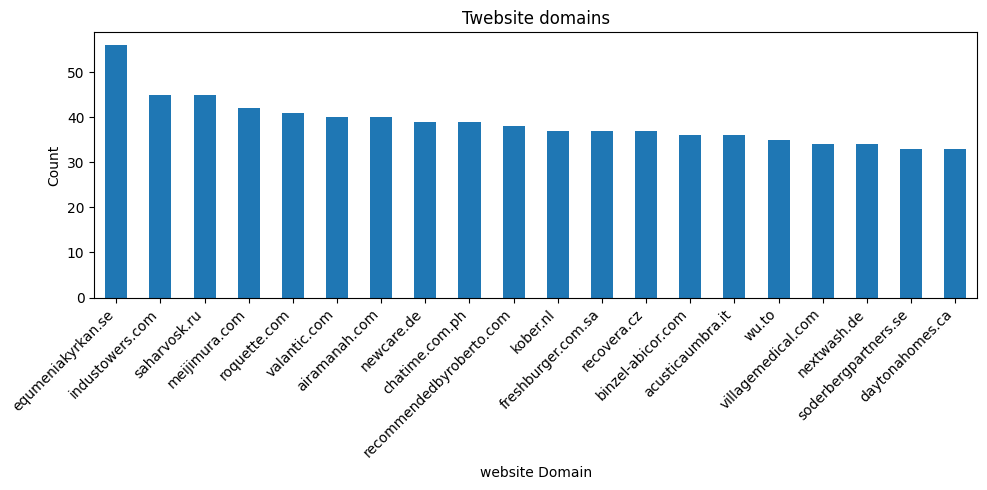

In [8]:
import matplotlib.pyplot as plt

# name_lengths = df['company_name'].str.len().dropna()
# plt.figure(figsize=(8, 4))
# plt.hist(name_lengths, bins=40)
# plt.xlabel('Company name len')
# plt.ylabel('Number of companies')
# plt.title('Distribution of company name length')
# plt.show()

top_domains = df['website_domain'].value_counts().nlargest(20)
plt.figure(figsize=(10, 5))
top_domains.plot(kind='bar')
plt.xlabel('website Domain')
plt.ylabel('Count')
plt.title('Twebsite domains')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
df['company_name_clean']            = clean(df['company_name'].fillna(''))
df['company_legal_names_clean']     = clean(df['company_legal_names'].fillna(''))
df['company_commercial_names_clean']= clean(df['company_commercial_names'].fillna(''))

for col in ['main_country_code','main_region','main_city_district']:
    df[col] = (
        df[col].fillna('')
               .str.lower()
            #    and also replace the punctuations if any
               .str.replace(r'[+,–()\-\']', '', regex=True)
               .str.strip()
    )

# drop suffixes, these are handpicked
SUFFIXES = ['inc','incorporated','ltd','llc','corp','co','company','gmbh','plc','sa']
suffix_re = re.compile(r'\b(?:' + '|'.join(SUFFIXES) + r')\b\.?', flags=re.IGNORECASE)
df['company_name_norm'] = (
    df['company_name_clean']
      .str.replace(suffix_re, '', regex=True)
      .str.replace(r'\s+', ' ', regex=True)
      .str.strip()
)


# in the dataset i see that they are divided by pipe
def make_set(prime, multi):
    multi_sets = multi.fillna('').str.split('|') \
                   .apply(lambda lst: {x.strip() for x in lst if x.strip()})
    prime_sets = prime.fillna('').apply(lambda x: {x.strip()} if x.strip() else set())
    return multi_sets.combine(prime_sets, lambda a, b: a | b)

df['phone_set'] = make_set(df['primary_phone'], df['phone_numbers'])
df['email_set'] = make_set(df['primary_email'],    df['emails'])

# we want to compare the names
indexer = recordlinkage.Index()
indexer.block('company_name_norm')
pairs = indexer.index(df)

compare = recordlinkage.Compare()
compare.string('company_name_norm', 'company_name_norm',
               method='jarowinkler', threshold=0.9, label='name')
compare.exact('website_domain', 'website_domain', label='domain')

features = compare.compute(pairs, df)

phone_matches = []
email_matches = []
for u, v in features.index:
    phone_matches.append(bool(df.at[u, 'phone_set'] & df.at[v, 'phone_set']))
    email_matches.append(bool(df.at[u, 'email_set'] & df.at[v, 'email_set']))

features['phone'] = phone_matches
features['email'] = email_matches


# i want a pair of flags that is overlapping
matches = features[(features[['name','domain','phone','email']].sum(axis=1) >= 2)]

parent = {}
def find(u):
    parent.setdefault(u, u)
    if parent[u] != u:
        parent[u] = find(parent[u])
    return parent[u]

def union(u, v):
    parent[find(u)] = find(v)

for u, v in matches.index:
    union(u, v)

df['cluster_id'] = df.index.map(lambda i: find(i) if i in parent else -1)
roots = {r: idx for idx, r in enumerate({find(i) for i in parent})}
df['cluster_id'] = df['cluster_id'].map(lambda r: roots.get(r, -1))

deduped = df.groupby('cluster_id').first().reset_index(drop=True)

In [10]:
deduped.groupby('company_name').size().sort_values(ascending=False)
# df.groupby('website_domain').size().sort_values(ascending=False)

company_name
Avane Cloud Kitchens                           2
Just Be Well Massage                           2
Manta Ray Records                              2
Shaffers Market                                2
Standard Chartered Securities India Limited    2
                                              ..
van der Werff Louis                            1
vwma                                           1
vytautas zaunieravicius IĮ APSAUGA             1
xquer GmbH                                     1
180 Chicago Church                             1
Length: 5955, dtype: int64

In [11]:
# this was one of the examples in a iteration
# company_name
# Avane Cloud Kitchens                           2
# Just Be Well Massage                           2
# Manta Ray Records                              2
# Shaffers Market                                2
# Standard Chartered Securities India Limited    2
#                                               ..
# van der Werff Louis                            1
# vwma                                           1
# vytautas zaunieravicius IĮ APSAUGA             1
# xquer GmbH                                     1
# 180 Chicago Church                             1
# and that is because one of the domains has a redirect to the other url which means the information is old 

deduped[deduped['company_name'] == "Just Be Well Massage"]

,company_name,company_legal_names,company_commercial_names,main_country_code,main_region,main_city_district,main_latitude,main_longitude,locations,num_locations,business_tags,business_model,product_type,naics_2022_primary_code,main_business_category,main_industry,main_sector,primary_phone,phone_numbers,primary_email,emails,website_url,website_domain,website_tld,sic_codes,isic_v4_codes,domains,all_domains,company_name_clean,company_legal_names_clean,company_commercial_names_clean,company_name_norm,phone_set,email_set
1689,Just Be Well Massage,None,Just Be Well Massage,us,california,old town,32.7444888,-117.21146879999999,"US, United States, California, San Diego, 9211...",1,Wellness Massage | Therapeutic Massages | Mass...,Services,Consumer Services,621399,Massage Therapists,Therapy & Alternative Medicine,Health Care & Social Assistance,+18088688498,+18088688498,None,None,http://www.justbewellmassage.com/,justbewellmassage.com,com,8049 | 8093,8690,justbewellmassage.wordpress.com | justbewellma...,justbewellmassage.wordpress.com | justbewellma...,just be well massage,,just be well massage,just be well massage,{+18088688498},{}
3737,Just Be Well Massage,None,Just Be Well Massage,us,california,,32.9563179,-117.04772369999999,"US, United States, California, Poway, 92064, P...",1,None,Services,Consumer Services,None,Massage Therapists,Therapy & Alternative Medicine,Health Care & Social Assistance,None,None,justbewellmassage@gmail.com,None,https://justbewellmassage.wordpress.com/treatm...,justbewellmassage.wordpress.com,com,None,None,justbewellmassage.wordpress.com,justbewellmassage.wordpress.com,just be well massage,,just be well massage,just be well massage,{},{}


In [12]:
# so lets build a redirect website url and see where is that taking us to the final website
# important to note here, i assume that your dataset is build overtime, you dont build it everyday that's why we have old website


# and one thing its very hard to paralelize things in python with thread beause you have the GIL which lets you execute python code line by line, but becasuse we are doing i/o
# it should work better
import pandas as pd
import requests
from urllib.parse import urlparse
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm  # im only using it to see progress



# just so you know:)) the first time i did it raw and after 50 minutes I said I think i should paralize it
def get_final_domain(domain):
    if not domain or pd.isna(domain):
        return ''
    for scheme in ('https://', 'http://'):
        try:
            url = requests.get(f'{scheme}{domain}', timeout=5, allow_redirects=True).url
            return urlparse(url).netloc.lower()
        except Exception:
            pass
    return domain.lower()

unique_domains = df['website_domain'].dropna().unique()
redirect_map = {}

with ThreadPoolExecutor(max_workers=50) as executor:
    futures = {executor.submit(get_final_domain, d): d for d in unique_domains}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Resolving"):
        dom = futures[future]
        try:
            redirect_map[dom] = future.result()
        except Exception:
            redirect_map[dom] = dom.lower()

df['final_domain'] = df['website_domain'].map(lambda d: redirect_map.get(d, '').lower())


Resolving: 100%|██████████| 6613/6613 [23:36<00:00,  4.67it/s] 


In [ ]:
def clean_loc(s):
    parts = [p.strip().lower() for p in str(s).split(',') if p.strip()]
    return ', '.join(parts)
df['loc_norm'] = df['locations'].fillna('').apply(clean_loc)

indexer = recordlinkage.Index()
indexer.block('company_name_norm')
pairs = indexer.index(df)

compare = recordlinkage.Compare()
compare.string('company_name_norm', 'company_name_norm',
               method='jarowinkler', threshold=0.9, label='name')
compare.exact('final_domain', 'final_domain', label='domain')

# as a bonus we are taking in consideration the location
compare.string('loc_norm','loc_norm',
               method='jarowinkler', threshold=0.85, label='location')

features = compare.compute(pairs, df)

phone_matches = []
email_matches = []
for u, v in features.index:
    phone_matches.append(bool(df.at[u, 'phone_set'] & df.at[v, 'phone_set']))
    email_matches.append(bool(df.at[u, 'email_set'] & df.at[v, 'email_set']))

features['phone'] = phone_matches
features['email'] = email_matches

# i want a pair of flags that is overlapping
matches = features[(features[['name','domain','location', 'phone','email']].sum(axis=1) >= 2)]

parent = {}
def find(u):
    parent.setdefault(u, u)
    if parent[u] != u:
        parent[u] = find(parent[u])
    return parent[u]
def union(u, v):
    parent[find(u)] = find(v)

for u, v in matches.index:
    union(u, v)

df['cluster_id'] = df.index.map(lambda i: find(i) if i in parent else -1)
roots = {r: idx for idx, r in enumerate({find(i) for i in parent})}
df['cluster_id'] = df['cluster_id'].map(lambda r: roots.get(r, -1))


unassigned = df['cluster_id'] == -1
max_id = df['cluster_id'].max()
df.loc[unassigned, 'cluster_id'] = range(max_id + 1, max_id + 1 + unassigned.sum())


deduped = df.groupby('cluster_id').first().reset_index(drop=True)

In [25]:
deduped.groupby('company_name').size().sort_values(ascending=False)

company_name
Campo Noble                           2
APTA Academy of Education             2
Chubbsafes                            2
Meishoku Co. Ltd.                     2
Spectrum Security Products            2
                                     ..
van der Werff Louis                   1
vwma                                  1
vytautas zaunieravicius IĮ APSAUGA    1
xquer GmbH                            1
A-LAN Technologie Spółka              1
Length: 6078, dtype: int64

In [ ]:
# an example of 2 compenies that are not duplicated
deduped[deduped['company_name'] == "Campo Noble"]

,company_name,company_legal_names,company_commercial_names,main_country_code,main_region,main_city_district,main_latitude,main_longitude,locations,num_locations,business_tags,business_model,product_type,naics_2022_primary_code,main_business_category,main_industry,main_sector,primary_phone,phone_numbers,primary_email,emails,website_url,website_domain,website_tld,sic_codes,isic_v4_codes,domains,all_domains,company_name_clean,company_legal_names_clean,company_commercial_names_clean,company_name_norm,phone_set,email_set,final_domain,loc_norm
2683,Campo Noble,None,Campo Noble,cl,,,None,None,"CL, Chile, , , , , , -31.7613365, -71.3187697",1,None,Services,Consumer Services,711310,Event Planner Services,Entertainment,"Arts, Entertainment & Recreation",None,None,None,None,https://www.tiendacamponoble.cl/,tiendacamponoble.cl,cl,7941 | 6512 | 7389 | 7922 | 7999,9000 | 9311 | 9319 | 9329,concursos-camponoble.cl,concursos-camponoble.cl,campo noble,,campo noble,campo noble,{},{},tiendacamponoble.cl,"cl, chile, -31.7613365, -71.3187697"
3555,Campo Noble,None,Campo Noble,cl,región del maule,,-35.457074399999996,-71.6482822,"CL, Chile, Región del Maule, Maule, 3461761, R...",1,Recipe Books | Pork Cuts | Smoked Meat | Retai...,Retail,Nondurable Products,445250,"Meat, Fish & Seafood Stores","Meat, Poultry & Dairy",Food & Beverages,+56712616339,+56712616339,saladeventas@coexca.cl,None,http://camponoble.cl/?opi=79508299&sa=U&ved=0a...,camponoble.cl,cl,5961 | 5142 | 5961 | 5421 | 5146 | 5961 | 5431...,4781 | 4721 | 4791 | 4799,camponoble.cl,camponoble.cl,campo noble,,campo noble,campo noble,{+56712616339},{},camponoble.cl,"cl, chile, región del maule, maule, 3461761, r..."


In [29]:
deduped

,company_name,company_legal_names,company_commercial_names,main_country_code,main_region,main_city_district,main_latitude,main_longitude,locations,num_locations,business_tags,business_model,product_type,naics_2022_primary_code,main_business_category,main_industry,main_sector,primary_phone,phone_numbers,primary_email,emails,website_url,website_domain,website_tld,sic_codes,isic_v4_codes,domains,all_domains,company_name_clean,company_legal_names_clean,company_commercial_names_clean,company_name_norm,phone_set,email_set,final_domain,loc_norm
0,AAA Auto Otrokovice Zlín,Zafari Inc.,AAA Auto Otrokovice Zlín,cz,zlín,kvítkovice u otrokovic,49.19930449999999,17.545311599999998,"CZ, Czechia, Zlín, Otrokovice, 765 02, Zlínská...",1,Portraits & Events | Wedding Cinematography | ...,Retail,Durable Products,441120,Automobile Dealers & Manufacturers,Automobile Dealers & Manufacturers,Automotive,+420800400450,+420800400450,franortiz@franortiz.com,rrhh@centrosquimeyco.com.ar | info@centrosquim...,https://www.aaaauto.cz/?bsw=251,aaaauto.cz,cz,5521,4510,franortiz.com,franortiz.com,aaa auto otrokovice zln,,aaa auto otrokovice zln,aaa auto otrokovice zln,{+420800400450},{},www.aaaauto.cz,"cz, czechia, zlín, otrokovice, 765 02, zlínská..."
1,Owens Liquors,OWENS LIQUORS INC.,Owens Liquors,us,south carolina,,33.4798501,-79.1001306,"US, United States, South Carolina, Pawleys Isl...",1,None,Retail,Nondurable Products,445320,Beer & Liquor Stores,Beverages,Food & Beverages,+18433140354,+18433140354,None,None,https://pawleysisland.owensliquors.com/,owensliquors.com,com,5411 | 5431 | 5142 | 5961 | 5921 | 5961 | 5181...,4722 | 4781 | 4791 | 4799,owensliquors.com,owensliquors.com,owens liquors,,owens liquors,owens liquors,{+18433140354},{},owensliquors.com,"us, united states, south carolina, pawleys isl..."
2,Club Tarneit,None,Club Tarneit,au,victoria,tarneit,-37.8341253,144.70173590000002,"AU, Australia, Victoria, City of Wyndham, 3029...",1,Events & Service,Services,Consumer Services,722410,Dance Clubs & Night Clubs,Pubs & Bars,Accommodation & Food Services,+61387541300,+61387541300,info@clubtarneit.com.au,info@clubtarneit.com.au,https://www.clubtarneit.com.au/,clubtarneit.com.au,com.au,5813,5630,clubtarneit.com.au,clubtarneit.com.au,club tarneit,,club tarneit,club tarneit,{},{},clubtarneit.com.au,"au, australia, victoria, city of wyndham, 3029..."
3,Gisinger GmbH,Gisinger GmbH,None,de,badenwürttemberg,,47.7134802,8.285150677517294,"DE, Germany, Baden-Württemberg, Ühlingen-Birke...",1,None,Services,Professional Services,485310,Taxicabs,Passenger Transport Services,Transport & Warehousing,+497743213,+497743213,None,None,https://www.gisinger-gmbh.de/,gisinger-gmbh.de,de,4899 | 4121,4922 | 5221,gisinger-gmbh.de,gisinger-gmbh.de,gisinger gmbh,gisinger gmbh,,gisinger,{},{},,"de, germany, baden-württemberg, ühlingen-birke..."
4,Kasana Life,None,Kasana Life,us,connecticut,,41.74637023463944,-73.19786993293546,"US, United States, Connecticut, Litchfield, 06...",2,Essential OIls | Reflexology | Teaching Certif...,Services,Consumer Services,713940,Yoga Studios,Recreational Sports Centers,"Arts, Entertainment & Recreation",+19174887460,+19174887460,kristin@kasanalife.com,info@kasanalife.com,https://www.kasanalife.com/,kasanalife.com,com,7997 | 7991 | 7999,9311,kasanalife.com,kasanalife.com,kasana life,,kasana life,kasana life,{+19174887460},{},,"us, united states, connecticut, litchfield, 06..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6160,Maxine Siggers Acupuncture,None,Maxine Siggers Acupuncture,gb,england,,51.7971183,-0.7887502999999999,"GB, United Kingdom, England, Aylesbury, , , , ...",1,Acupuncturist,Services,Consumer Services,621399,Acupuncture clinic,Therapy & Alternative Medicine,Health Care & Social Assistance,+447776133824,+447776133824,maxine@siggers.co.uk,None,https://www.maxinesiggers.co.uk/,maxinesiggers.co.uk,co.uk,8049 | 8093,8690,None,None,maxi

In [30]:
# the task said to grouped them, so i concatenate them (only unique values)
def concat_unique(x):
    vals = x.dropna().astype(str).unique()
    return '|'.join(vals)

deduped_full = (
    df
    .groupby('cluster_id')
    .agg({col: concat_unique for col in df.columns if col != 'cluster_id'})
    .reset_index()
)

deduped_full

,cluster_id,company_name,company_legal_names,company_commercial_names,main_country_code,main_region,main_city_district,main_latitude,main_longitude,locations,num_locations,business_tags,business_model,product_type,naics_2022_primary_code,main_business_category,main_industry,main_sector,primary_phone,phone_numbers,primary_email,emails,website_url,website_domain,website_tld,sic_codes,isic_v4_codes,domains,all_domains,company_name_clean,company_legal_names_clean,company_commercial_names_clean,company_name_norm,phone_set,email_set,final_domain,loc_norm
0,-1,AAA Auto Otrokovice Zlín|BAM BROW & MAKEUP STU...,Zafari Inc.|NOB NET ON BRAZIL LTDA|Clean Pty L...,AAA Auto Otrokovice Zlín|BAM BROW & MAKEUP STU...,cz|au|in|nz||us|ar|it|jp|de|br|gb|fr|cn|ca|ba|...,zlín|western australia|kerala|auckland||utah|b...,kvítkovice u otrokovic||jardim helena|radcliff...,49.19930449999999|-36.989383000000004|-34.6650...,17.545311599999998|174.885087|-58.683088|11.42...,"CZ, Czechia, Zlín, Otrokovice, 765 02, Zlínská...",1|2|6|5|10|47|21|36|3|24|19|26|8|12|4|9|33|49|...,Portraits & Events | Wedding Cinematography | ...,Retail|Services|Wholesale|Non Profit|Manufactu...,Durable Products|Consumer Services|Professiona...,441120|621210|541921|531130|624120|713940|4581...,Automobile Dealers & Manufacturers|Dentists & ...,Automobile Dealers & Manufacturers|Dentists & ...,Automotive|Health Care & Social Assistance|Oth...,+420800400450|+648002622208|+34625223431|+1801...,+420800400450|+648002622208|+34625223431|+1801...,franortiz@franortiz.com|wxstorage@gmail.com|rr...,rrhh@centrosquimeyco.com.ar | info@centrosquim...,https://www.aaaauto.cz/?bsw=251|https://www.ba...,aaaauto.cz|bammakeupstudio.com.au|happywedding...,cz|com.au|com|co.nz|net|com.ar|it|co.jp|de|com...,5521|8021|7221|4225 | 6798|8322|7997 | 7991 | ...,4510|8620|7420|6810|8810|9311|4771 | 4773 | 47...,franortiz.com|stocknlock.net | woodscrossutahs...,franortiz.com|stocknlock.net | woodscrossutahs...,aaa auto otrokovice zln|bam brow makeup studio...,|zafari inc|nob net on brazil ltda|clean pty l...,aaa auto otrokovice zln|bam brow makeup studio...,aaa auto otrokovice zln|bam brow makeup studio...,{'+420800400450'}|set()|{'+648002622208'}|{'+3...,set()|{'franortiz@franortiz.com'}|{'wxstorage@...,www.aaaauto.cz|bammakeupstudio.com.au|happywed...,"cz, czechia, zlín, otrokovice, 765 02, zlínská..."
1,0,Owens Liquors|OWENS LIQUORS INC.,OWENS LIQUORS INC.,Owens Liquors,us,south carolina,,33.4798501|33.750308990478516|33.7497256,-79.1001306|-78.8149642944336|-78.8147152,"US, United States, South Carolina, Pawleys Isl...",1,,Retail,Nondurable Products,445320,Beer & Liquor Stores,Beverages,Food & Beverages,+18433140354|+18434496833,+18433140354|+18434496833,,,https://pawleysisland.owensliquors.com/|https:...,owensliquors.com,com,5411 | 5431 | 5142 | 5961 | 5921 | 5961 | 5181...,4722 | 4781 | 4791 | 4799,owensliquors.com,owensliquors.com,owens liquors|owens liquors inc,|owens liquors inc,owens liquors|,owens liquors,{'+18433140354'}|{'+18434496833'}|set(),set(),owensliquors.com,"us, united states, south carolina, pawleys isl..."
2,1,Club Tarneit,,Club Tarneit,au,victoria,tarneit|truganina,-37.8341253|-37.8367659|-37.8355565|-37.8295297,144.70173590000002|144.7157517|144.7032249|144...,"AU, Australia, Victoria, City of Wyndham, 3029...",1|2,Events & Service|Sport Bars | Dining Experienc...,Services,Consumer Services,722410,Dance Clubs & Night Clubs|Wedding Venues|Pubs ...,Pubs & Bars|Restaurants,Accommodation & Food Services,+61387541300,+61387541300,info@clubtarneit.com.au,info@clubtarneit.com.au,https://www.clubtarneit.com.au/|http://www.clu...,clubtarneit.com.au,com.au,5813,5630,clubtarneit.com.au,clubtarneit.com.au,club tarneit,,club tarneit,club tarneit,set()|{'+61387541300'},set()|{'info@clubtarneit.com.au'},clubtarneit.com.au,"au, australia, victoria, city of wyndham, 3029..."
3,2,Gisinger GmbH,Gisinger GmbH,,de,badenwürttemberg,,47.7134802|47.71355,8.285150677517294|8.28516,"DE, Germany, Baden-Württemb

In [31]:
deduped_full.to_parquet('deduped_full.parquet', index=False)